# Class 24: Spatial Data, OSMNX, GeoPandas

Goal of today's class:
1. Introduce shapefiles
2. Introduce `geopandas` for spatial tasks
3. Integrate what we learned with `osmnx`

__________

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Open up the Jupyter Lab terminal.
5. Activate Conda: `module load anaconda3/2022.05`
6. Activate the shared virtual environment: `source activate /courses/PHYS7332.202510/shared/ox/`
7. Run `python3 git_fixer2.py`
8. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main
________

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

## Introduction: Random Geometric Graphs

Random geometric graphs (RGGs) are spatially-embedded networks where the probability $p_{ij}$ that any pair of nodes is connected is a function of the distance between $i$ and $j$. RGGs differ from classical random graphs (e.g., Erdős-Rényi graphs) by embedding nodes in space, imposing locality constraints on edge formation. This makes RGGs particularly useful for studying networks with spatial dependencies. This paradigm is useful for studying systems ranging from wireless communication networks, to transportation systems, to certain biological networks (e.g. physical connections between neurons in a brain). 

A simple example of this is an RGG with $N$ nodes, each of which are connected if they are within a given radius, $r$, of each other. These nodes are embedded on a unit square or cube with Euclidean distance, but other spaces (e.g., toroidal, hyperbolic) can also be used. 


### Applications of RGGs

1. **Wireless Networks**
   - Nodes represent devices, and edges represent communication links. The radius \(r\) models signal range.
   - Analyze network robustness or connectivity under varying radii.

2. **Transportation Networks**
   - Nodes as cities or hubs, edges based on geographic proximity.
   - Study efficient routing or identify vulnerable regions.

3. **Social Networks**
   - Nodes as individuals in a physical space, edges based on interaction likelihood.
   - Explore clustering patterns in real-world social systems.


**References**

1. Penrose, M. D. (2003). *Random Geometric Graphs.* Oxford University Press. https://doi.org/10.1093/acprof:oso/9780198506263.001.0001
2. Gilbert, E. N. (1961). Random plane networks. *Journal of the Society for Industrial and Applied Mathematics*, 9(4), 533–543. https://doi.org/10.1137/0109045
3. Dall, J., & Christensen, M. (2002). Random geometric graphs. *Physical Review E*, 66(1), 016121. https://doi.org/10.1103/PhysRevE.66.016121
4. Penrose, M. D. (1999). On $k$-connectivity for a geometric random graph. *Random Structures & Algorithms*, 15(2), 145–164. https://doi.org/10.1002/(SICI)1098-2418(199909)15:2%3C145::AID-RSA2%3E3.0.CO;2-G
5. Barthelemy, M. (2011). Spatial networks. *Physics Reports*, 499(1–3), 1–101. https://doi.org/10.1016/j.physrep.2010.11.002
6. Haenggi, M. (2009). *Stochastic Geometry for Wireless Networks.* Cambridge University Press. https://doi.org/10.1017/CBO9781139043816
7. Eppstein, D., Goodrich, M. T., & Trott, L. (2009, November). Going off-road: transversal complexity in road networks. In Proceedings of the 17th *ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems* (pp. 23-32). https://doi.org/10.1145/1653771.1653778

### Creating an RGG in Python

In [2]:
np.random.seed(5)
N = 100
r = 0.19 # Connection radius

# Randomly place nodes in a unit square
positions = np.random.rand(N, 2)

In [3]:
# Create the graph
G = nx.Graph()
G.add_nodes_from(list(range(N)))
pos = dict(zip(G.nodes(),positions))

In [4]:
# Add edges based on Euclidean distance
for i in range(N):
    for j in range(i + 1, N):
        distance = np.linalg.norm(positions[i] - positions[j])
        if distance <= r:
            G.add_edge(i, j)

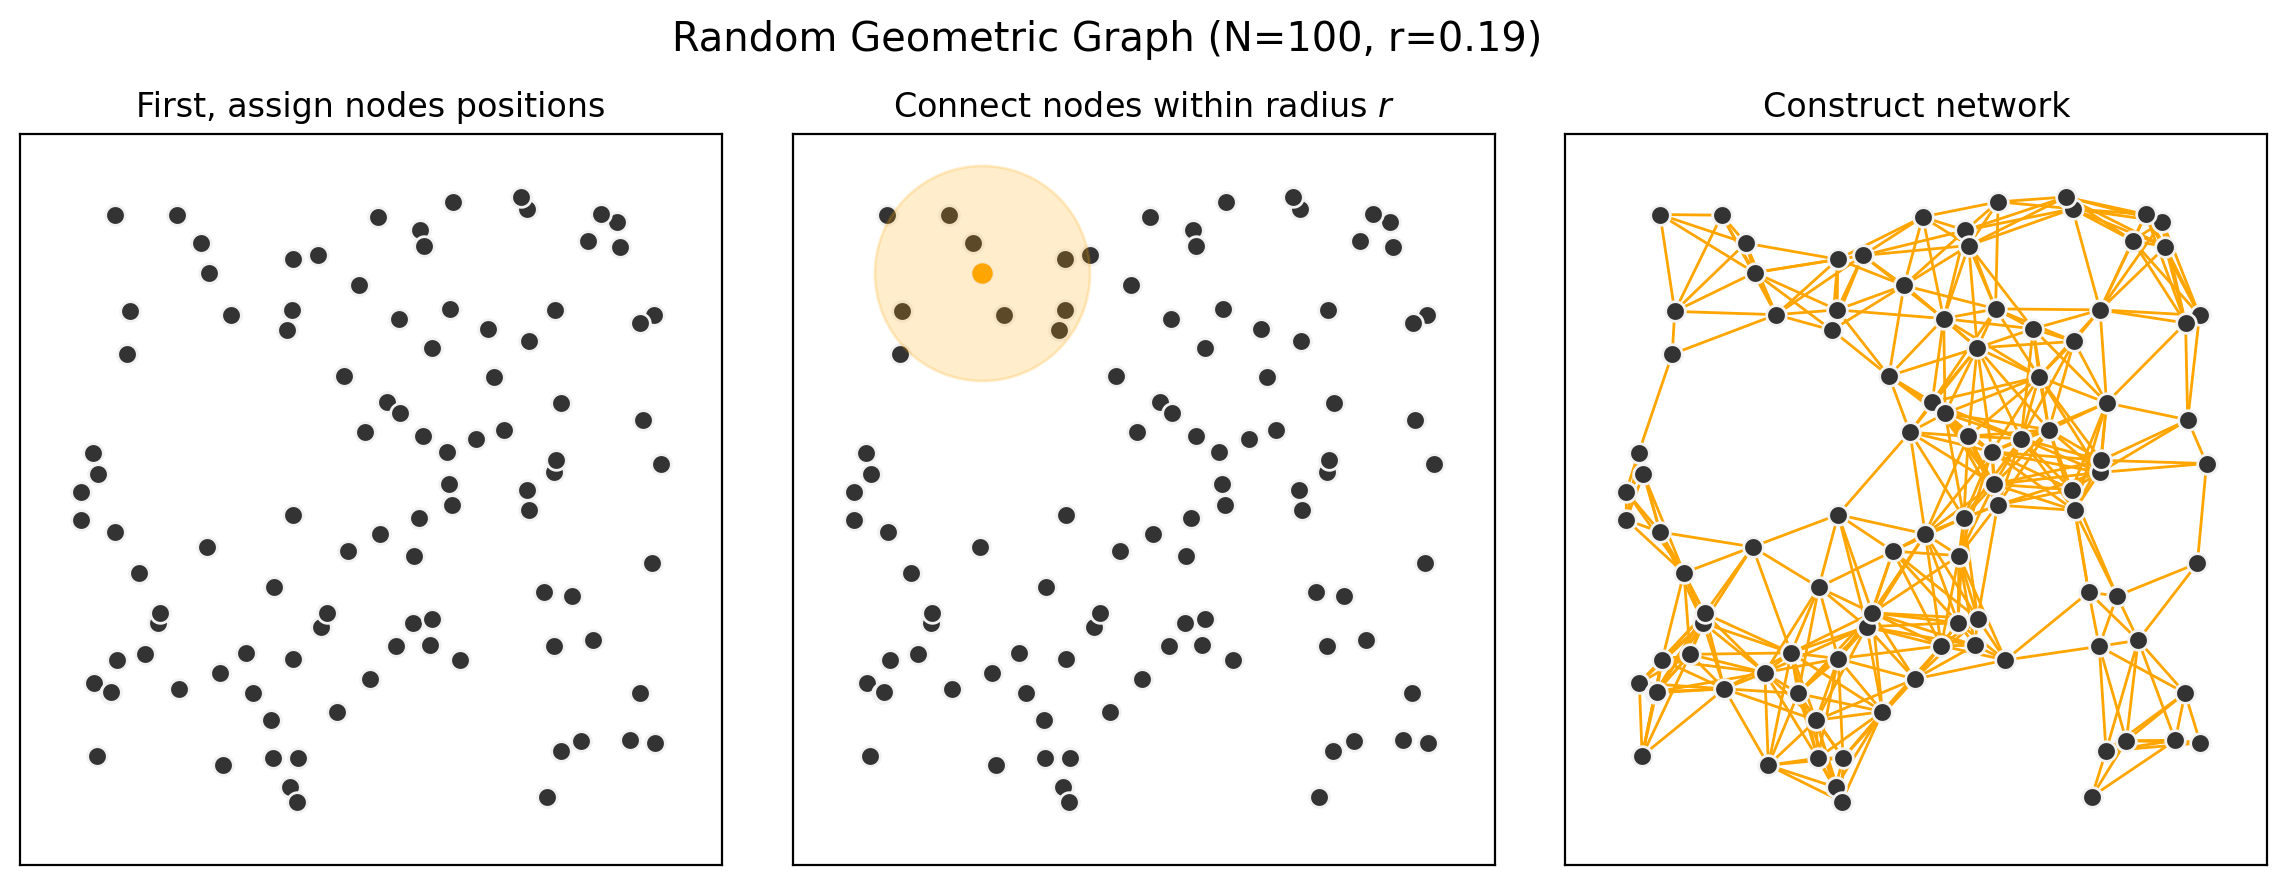

In [5]:
fig, ax = plt.subplots(1,3,figsize=(14.5,4.75),dpi=200,sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1)

# First
nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax[0], node_color='.2', edgecolors='.95')

# Second
nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax[1], node_color='.2', edgecolors='.95')
ax[1].scatter(positions[:,0][:1],positions[:,1][:1], s=40, color='orange', zorder=201)
ax[1].scatter(positions[:,0][:1],positions[:,1][:1], alpha=0.2, s=6000, color='orange', zorder=200)

# Third
nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax[2], node_color='.2', edgecolors='.95')
nx.draw_networkx_edges(G, pos, edge_color='orange', ax=ax[2])

ax[0].set_title('First, assign nodes positions')
ax[1].set_title('Connect nodes within radius $r$')
ax[2].set_title('Construct network')


plt.suptitle("Random Geometric Graph (N=%i, r=%.2f)"%(N,r),fontsize='x-large',y=1)


plt.show()

____
### Key Properties of RGGs
1. An important question in RGGs is the relationship between the connectivity radius $r$ and the number of nodes $n$. For a graph to be fully connected: $ r \propto \sqrt{\frac{\log n}{n}} $. This ensures that, as $n$ increases, the probability of the graph being connected approaches 1.

2. The clustering coefficient of an RGG tends to be high because nodes are connected based on spatial proximity, leading to local clusters. This is a distinguishing feature compared to random graphs like Erdős–Rényi graphs, where clustering is typically lower.

3. The degree of a node in an RGG is determined by the number of nodes within the radius $r$, which is proportional to the area of the neighborhood: $\langle k \rangle = n \pi r^2 $. For larger $n$, the degree distribution tends to follow a binomial distribution, approximated by a normal distribution.


In [6]:
niter = 100
n = 200
radii = np.linspace(0.05, 0.25, 201).round(5)

connected_mean = []
connected_stdv = []
for ri,r in enumerate(radii):
    if ri%10==0:
        print(np.round(r,5))
    tmp = []
    for _ in range(niter):
        G = nx.random_geometric_graph(n, r)
        tmp.append(nx.is_connected(G))

    connected_mean.append(np.mean(tmp))
    connected_stdv.append(np.std(tmp))


# convert to 
connected_mean = np.array(pd.Series(connected_mean).rolling(window=10,center=True).mean())
connected_stdv = np.array(pd.Series(connected_stdv).rolling(window=10,center=True).mean())

0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25


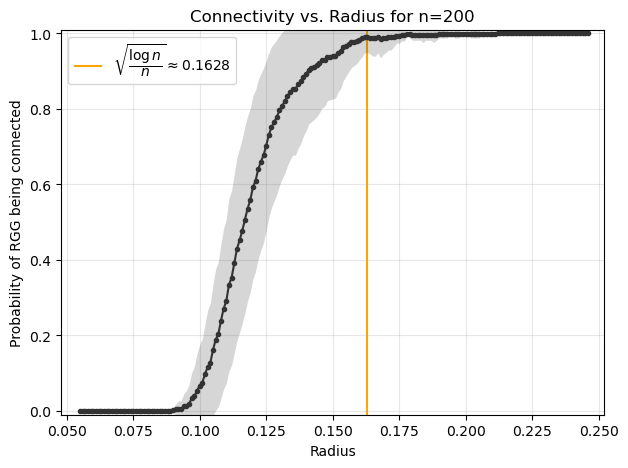

In [7]:
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)


ax.plot(radii, connected_mean, marker=".", color='.2')
ax.fill_between(radii,
                connected_mean-connected_stdv/2,
                connected_mean+connected_stdv/2,
                alpha=0.2, lw=0, color='.2')

ax.vlines(np.sqrt(np.log(n)/n),-1,2, color='orange', zorder=0,
          label=r'$\sqrt{\dfrac{\log n}{n}} \approx %.4f$'%(np.sqrt(np.log(n)/n)))

ax.legend()

ax.set_xlabel("Radius")
ax.set_ylabel("Probability of RGG being connected")
ax.set_title(f"Connectivity vs. Radius for n={n}")

ax.grid(alpha=0.3)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(min(radii)-0.002,max(radii)+0.002)


plt.show()

_____

### Your turn!

Repeatedly generate RGGs with $n=300$, and analyze how the average clustering coefficient changes with radius $r$. Create a plot of clustering coefficient vs. radius.

In [8]:
niter = 10
n = 200
radii = np.logspace(-3, 0.3, 51).round(5)

triangles_mean = []
triangles_stdv = []
cc_mean = []
cc_stdv = []
for ri,r in enumerate(radii):
    if ri%10==0:
        print(np.round(r,5))
    tmp = []
    tmp_cc = []
    for _ in range(niter):
        G = nx.random_geometric_graph(n, r)
        tt = nx.transitivity(G)
        tt = tt if not np.isnan(tt) else 1.0
        tmp.append(tt)
        tmp_cc.append(nx.average_clustering(G))

    triangles_mean.append(np.nanmean(tmp))
    triangles_stdv.append(np.nanstd(tmp))
    cc_mean.append(np.nanmean(tmp_cc))
    cc_stdv.append(np.nanstd(tmp_cc))


# convert to 
triangles_mean = np.array(pd.Series(triangles_mean).rolling(window=3,center=True).mean())
triangles_stdv = np.array(pd.Series(triangles_stdv).rolling(window=3,center=True).mean())

cc_mean = np.array(pd.Series(cc_mean).rolling(window=3,center=True).mean())
cc_stdv = np.array(pd.Series(cc_stdv).rolling(window=3,center=True).mean())

0.001
0.00457
0.02089
0.0955
0.43652
1.99526


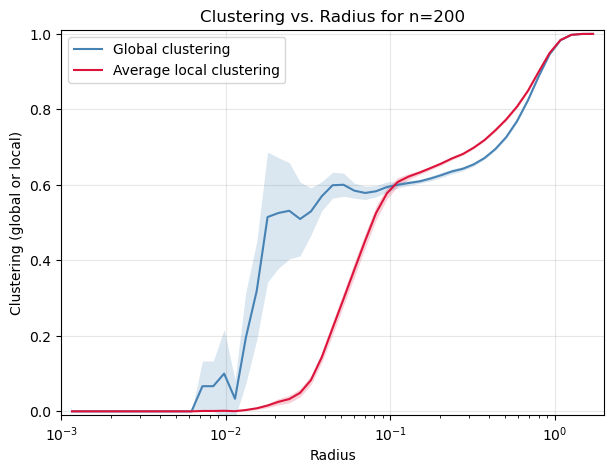

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)


ax.semilogx(radii, triangles_mean, color='steelblue', label='Global clustering')
ax.fill_between(radii,
                triangles_mean-triangles_stdv/2,
                triangles_mean+triangles_stdv/2,
                alpha=0.2, lw=0, color='steelblue')

ax.semilogx(radii, cc_mean, color='crimson', label='Average local clustering')
ax.fill_between(radii,
                cc_mean-cc_stdv/2,
                cc_mean+cc_stdv/2,
                alpha=0.2, lw=0, color='crimson')


ax.legend()

ax.set_xlabel("Radius")
ax.set_ylabel("Clustering (global or local)")
ax.set_title(f"Clustering vs. Radius for n={n}")

ax.grid(alpha=0.3)
ax.set_ylim(-0.01,1.01)
ax.set_xlim(min(radii),max(radii))


plt.show()

__________

## Open Street Maps NetworkX, aka `OSMnx`

From the [readthedocs](https://osmnx.readthedocs.io/en/stable/): "*OSMnx is a Python package to easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap. You can download and model walking, driving, or biking networks with a single line of code then analyze and visualize them. You can just as easily work with urban amenities/points of interest, building footprints, transit stops, elevation data, street orientations, speed/travel time, and routing.*"

### Key features of OSMnx

1. Network Retrieval: Automatically download and construct spatial networks from OpenStreetMap, specifying geographic boundaries (e.g., a city, region, or bounding box) or by name.
2. Customizability: Filter networks by type (e.g., walkable, drivable, bikeable), attributes (e.g., one-way streets, speed limits), or custom tags from OpenStreetMap.
3. Graph Representation: Represent spatial data as directed or undirected graphs, complete with geometric edge and node attributes for spatial analysis.
4. Visualization: Create static or interactive visualizations of networks with minimal effort, utilizing underlying geometric and topological properties.
5. Integration with GIS: Export networks and spatial data to standard GIS formats, such as Shapefiles and GeoPackages, for integration into broader geospatial workflows.

**References:**
1. Boeing, G. (2024). Modeling and Analyzing Urban Networks and Amenities with OSMnx. Working paper. https://geoffboeing.com/publications/osmnx-paper/
2. Boeing, G. (2017). OSMnx: New methods for acquiring, constructing, analyzing, and visualizing complex street networks. *Computers, Environment and Urban Systems*, 65, 126–139. https://doi.org/10.1016/j.compenvurbsys.2017.05.004.
3. Boeing, G. (2022). Street network models and indicators for every urban area in the world. *Geographical Analysis*, 54(3), 519-535. https://doi.org/10.1111/gean.12281.

_________
### Examples
Our first exploration comes from the terrific Examples Gallery of `osmnx`

https://github.com/gboeing/osmnx-examples/blob/main/notebooks/00-osmnx-features-demo.ipynb

![](images/osmnx_examples.png)

In [10]:
import osmnx as ox
ox.__version__

'2.0.0'

In [11]:
G = ox.graph_from_place("Boston, Massachusetts, USA", network_type="drive")

In [12]:
G.number_of_nodes(), G.number_of_edges()

(11138, 25495)

In [13]:
list(G.nodes(data=True))[:2]

[(30730954, {'y': 42.3676084, 'x': -71.0218168, 'street_count': 3}),
 (61178875, {'y': 42.3821495, 'x': -71.0808776, 'street_count': 4})]

In [14]:
list(G.edges(data=True))[:2]

[(30730954,
  61441677,
  {'osmid': 197230699,
   'highway': 'residential',
   'lanes': '2',
   'maxspeed': '25 mph',
   'name': 'Logan Memorial Way',
   'oneway': True,
   'reversed': False,
   'length': np.float64(33.07297223949995),
   'geometry': <LINESTRING (-71.022 42.368, -71.022 42.368, -71.022 42.368, -71.022 42.368)>}),
 (30730954,
  1102741801,
  {'osmid': 197230701,
   'highway': 'residential',
   'maxspeed': '25 mph',
   'name': 'Logan Memorial Way',
   'oneway': False,
   'reversed': False,
   'length': np.float64(278.88651649604105),
   'geometry': <LINESTRING (-71.022 42.368, -71.022 42.368, -71.022 42.368, -71.022 42.367,...>})]

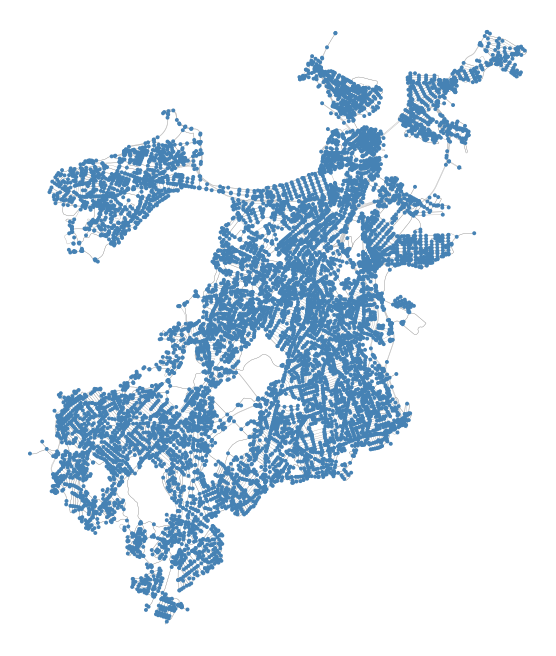

In [15]:
fig, ax = plt.subplots(1,1,figsize=(4,4),dpi=200)
ox.plot_graph(G, ax=ax, bgcolor='white', node_color='steelblue', node_size=2, edge_linewidth=0.1)

plt.show()

**From the OSMnx Features Demo notebook:**

*OSMnx geocodes the query "Boston, Massachusetts, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples. OSMnx models all networks as NetworkX MultiDiGraph objects. You can convert to:*

- *undirected MultiGraphs*
- *DiGraphs without (possible) parallel edges*
- *GeoPandas node/edge GeoDataFrames*

In [16]:
G = ox.graph_from_place("Roslindale, Massachusetts, USA", network_type="drive")

In [17]:
xpos = nx.get_node_attributes(G,'x')
ypos = nx.get_node_attributes(G,'y')
pos_init = {i:(xpos[i],ypos[i]) for i in G.nodes()}

In [18]:
np.random.seed(5)
pos_network = nx.spring_layout(G, pos=pos_init, k=0.001, iterations=200)

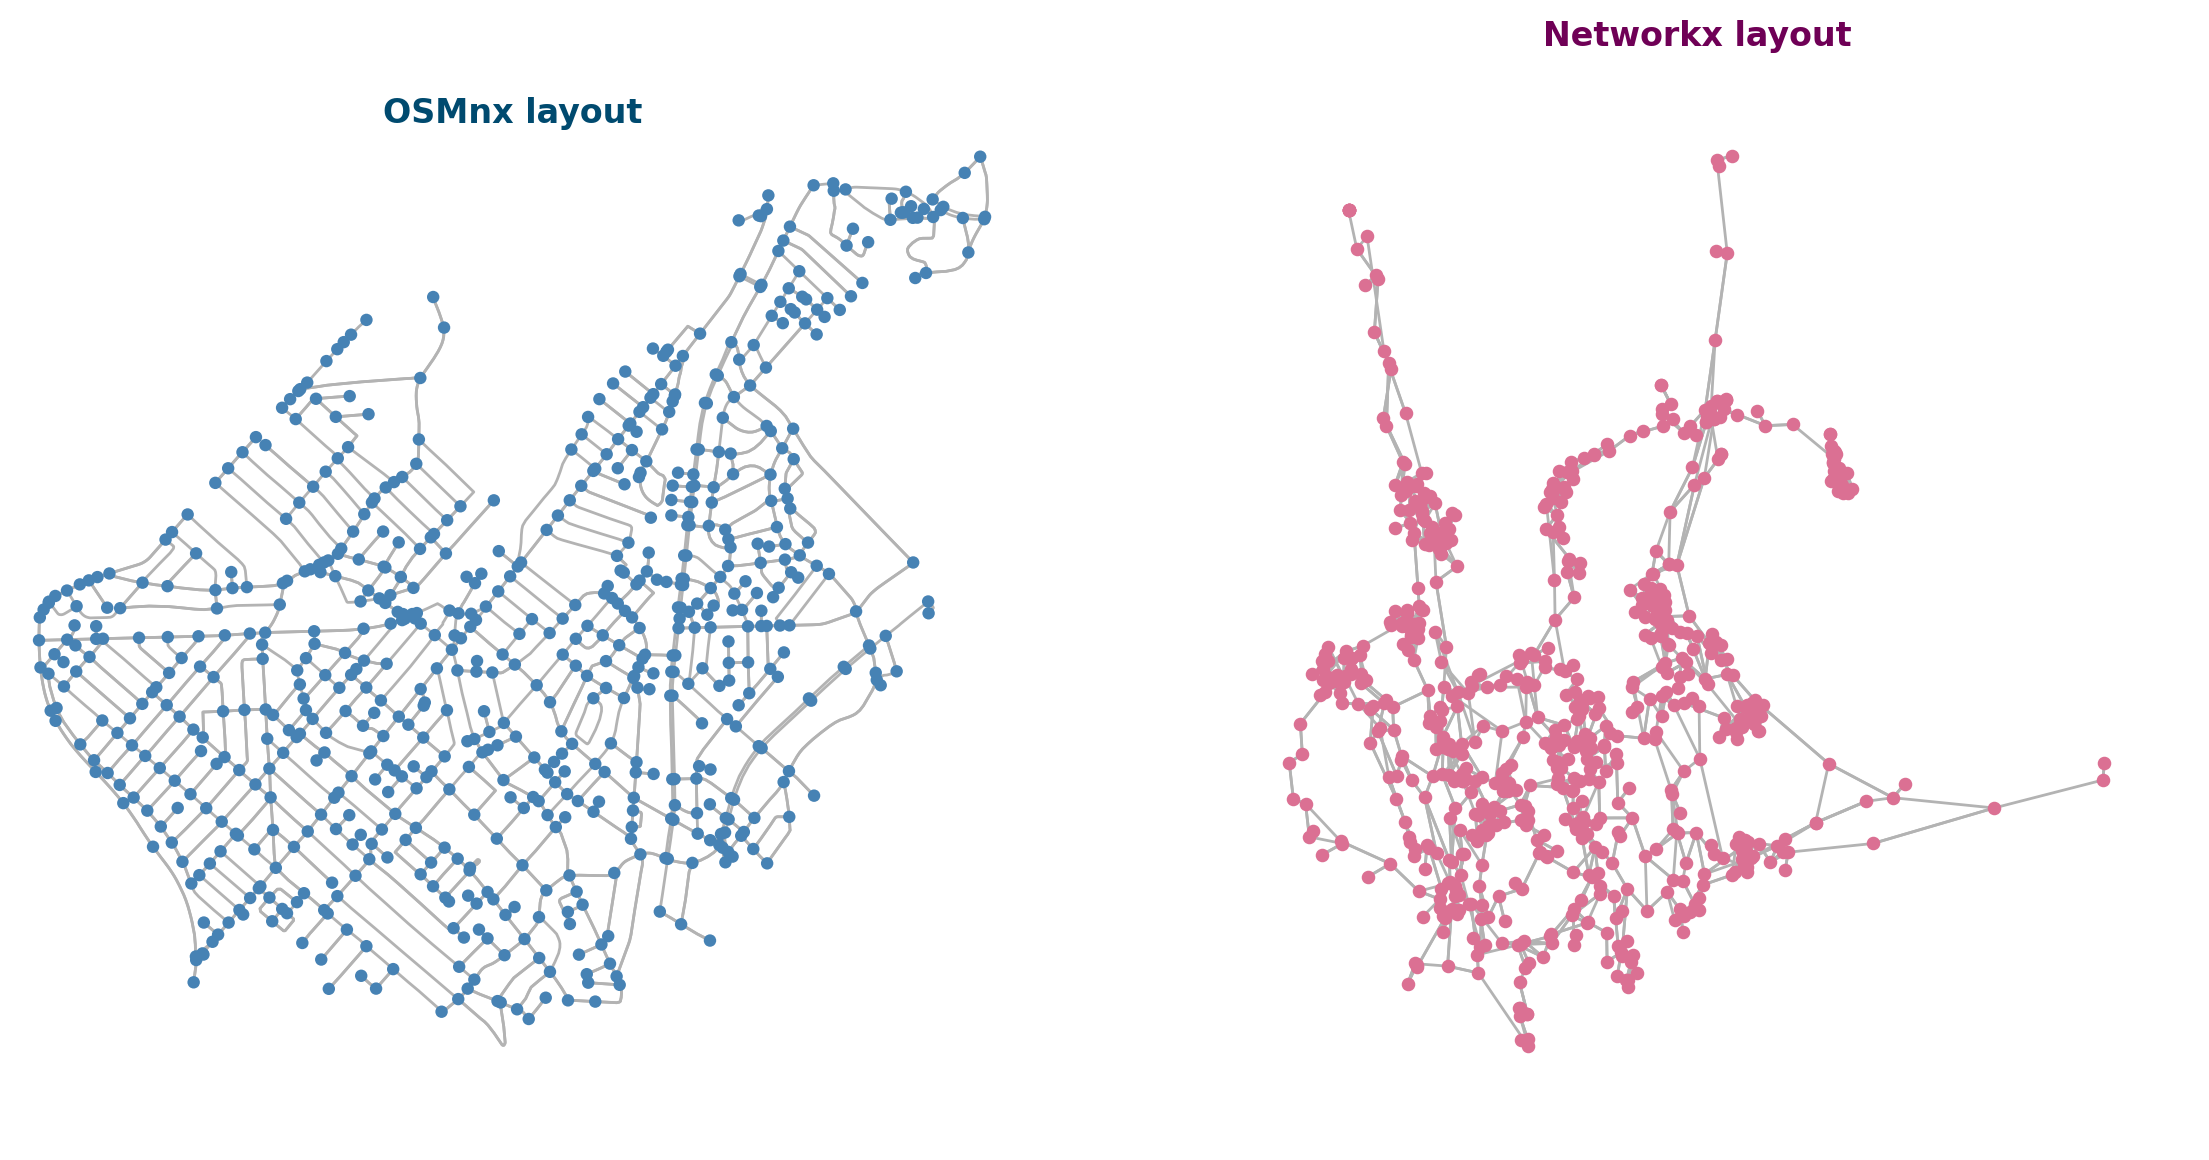

In [19]:
fig, ax = plt.subplots(1,2,figsize=(14,7),dpi=200)

nx.draw_networkx_nodes(G, pos=pos_network, node_size=15, node_color='palevioletred', ax=ax[1])
nx.draw_networkx_edges(G, pos=pos_network, edge_color='.7', width=1.0, arrows=False, ax=ax[1])
ax[1].set_axis_off()

ax[0].set_title('OSMnx layout',fontweight='bold',color='#004a6f')
ax[1].set_title('Networkx layout',fontweight='bold',color='#6f0056')

ox.plot_graph(G, ax=ax[0], bgcolor='white', node_color='steelblue', edge_color='.7', node_size=20)


plt.show()

___________

In [20]:
tags = {"building": True}
gdf = ox.features_from_place("Roslindale, Massachusetts, USA", tags)

In [21]:
gdf_proj = ox.projection.project_gdf(gdf)

In [22]:
bldg_colors = dict(zip(gdf_proj['building'].unique(),
                       plt.cm.tab20c(np.linspace(0,1,gdf_proj['building'].nunique()))))
bcs = [bldg_colors[i] for i in gdf_proj['building'].values]

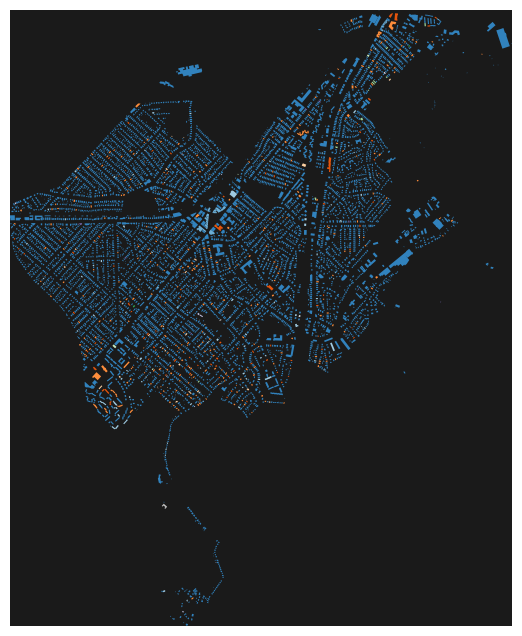

In [23]:
fig, ax = ox.plot_footprints(gdf_proj, bgcolor='.1',
                             color=bcs, dpi=400, show=False, close=False)

Roslindale, Massachusetts, USA
Jamaica Plain, Massachusetts, USA
Hyde Park, Massachusetts, USA
Roxbury, Massachusetts, USA
Allston, Massachusetts, USA
Brighton, Massachusetts, USA
Dorchester, Massachusetts, USA
South Boston, Massachusetts, USA
Charlestown, Massachusetts, USA


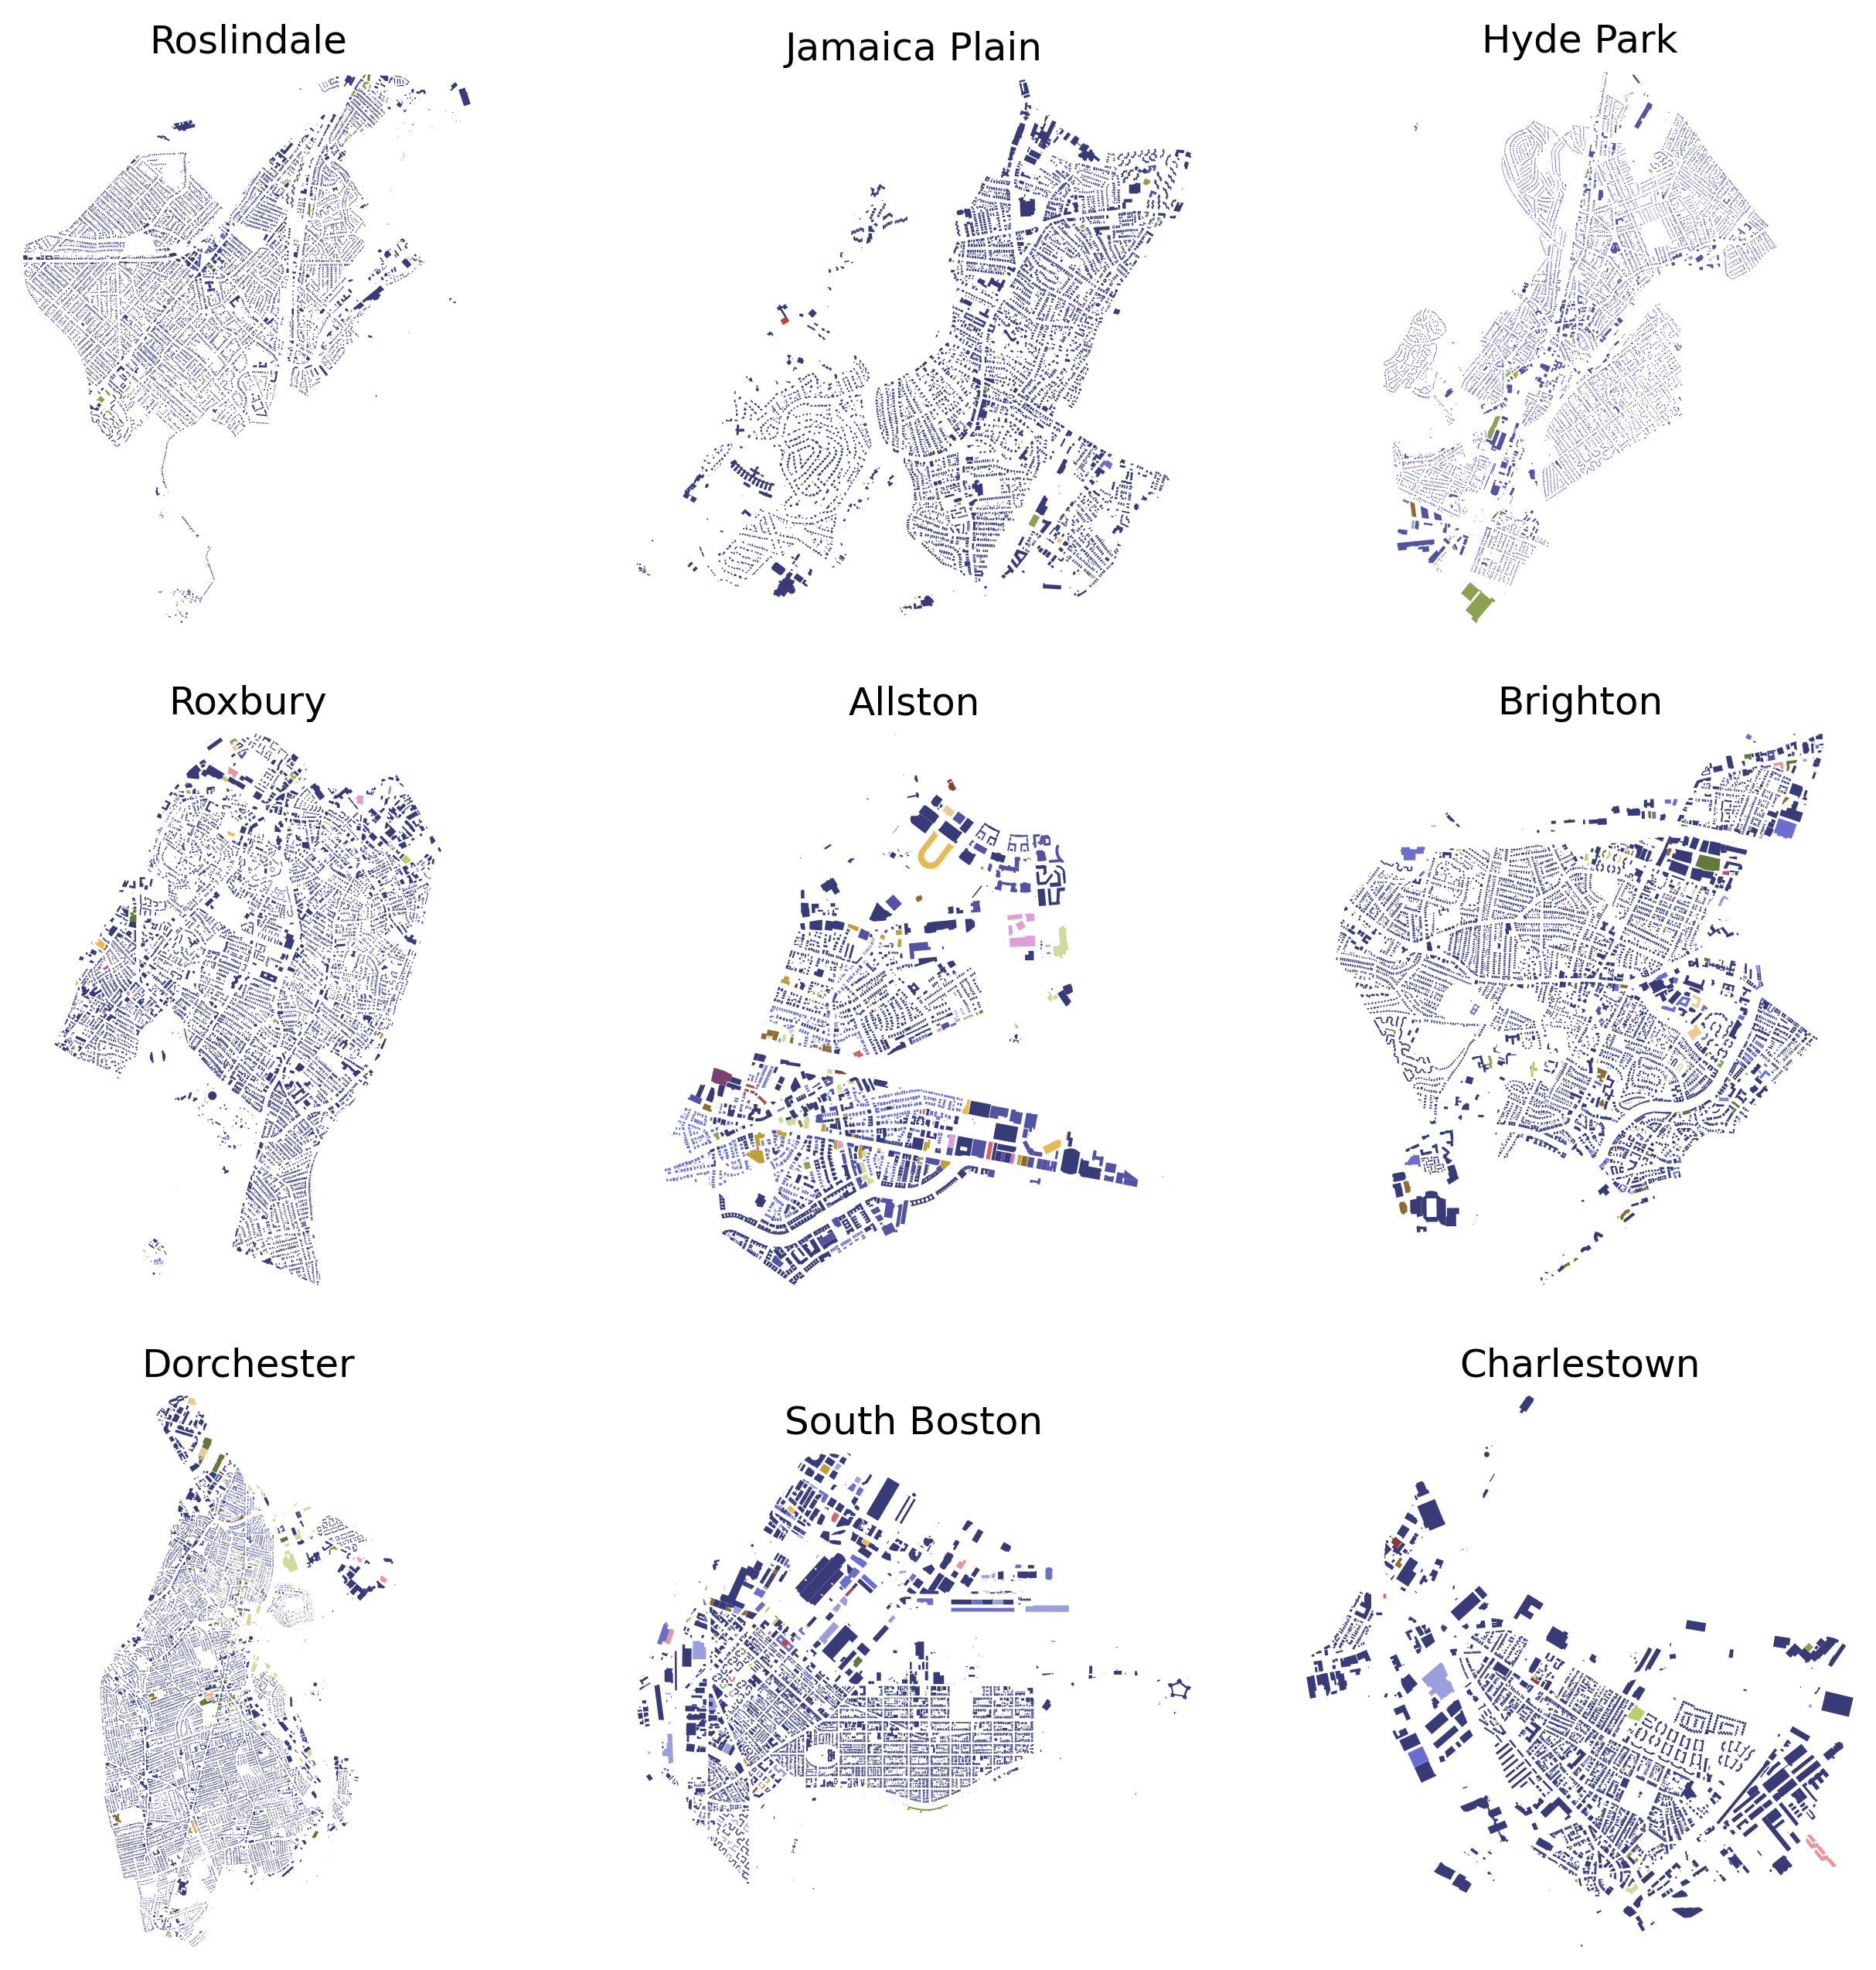

In [28]:
import itertools as it
ncols = 3
nrows = 3
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(nrows,ncols,figsize=(ncols*3.5,nrows*3.5),dpi=300)

neighborhoods = ["Roslindale, Massachusetts, USA", 
                 "Jamaica Plain, Massachusetts, USA",
                 "Hyde Park, Massachusetts, USA",
                 "Roxbury, Massachusetts, USA",
                 "Allston, Massachusetts, USA",
                 "Brighton, Massachusetts, USA",
                 "Dorchester, Massachusetts, USA",
                 "South Boston, Massachusetts, USA",
                 "Charlestown, Massachusetts, USA"]

for ix, neigh in enumerate(neighborhoods):
    print(neigh)
    gdf = ox.features_from_place(neigh, tags)
    gdf_proj = ox.projection.project_gdf(gdf)
    bldg_colors = dict(zip(gdf_proj['building'].unique(),
                           plt.cm.tab20b(np.linspace(0,1,gdf_proj['building'].nunique()))))
    bcs = [bldg_colors[i] for i in gdf_proj['building'].values]    
    ox.plot_footprints(gdf_proj, bgcolor='.1', ax=ax[tups[ix]],
                       color=bcs, dpi=400, show=False, close=False)
    ax[tups[ix]].set_title(neigh.split(',')[0])

plt.show()

___________

#### A little fun

In [29]:
bk_home = (42.28615490099605, -71.12870104902592)
one_mile = 1609  # meters
two_mile = one_mile*2  # meters
five_mile = one_mile*5  # meters
dist = one_mile
# dist = two_mile
# dist = five_mile
G = ox.graph_from_point(bk_home, dist=dist, network_type="walk")

In [30]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.convert.to_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.convert.to_digraph(G)

In [31]:
# api_key = ''
G = ox.elevation.add_node_elevations_google(G, api_key=api_key)
G = ox.elevation.add_edge_grades(G)

In [32]:
ehs1 = np.array(list(nx.edge_betweenness_centrality(G).values()))
mehs1 = (max(ehs1)-ehs1) / (max(ehs1)-min(ehs1))
ecs1 = plt.cm.magma(mehs1**50*0.9)

ehs2 = np.array(list(nx.get_edge_attributes(G, 'grade').values()))
mehs2 = (max(ehs2)-ehs2) / (max(ehs2)-min(ehs2))
ecs2 = plt.cm.Spectral_r(mehs2**2)

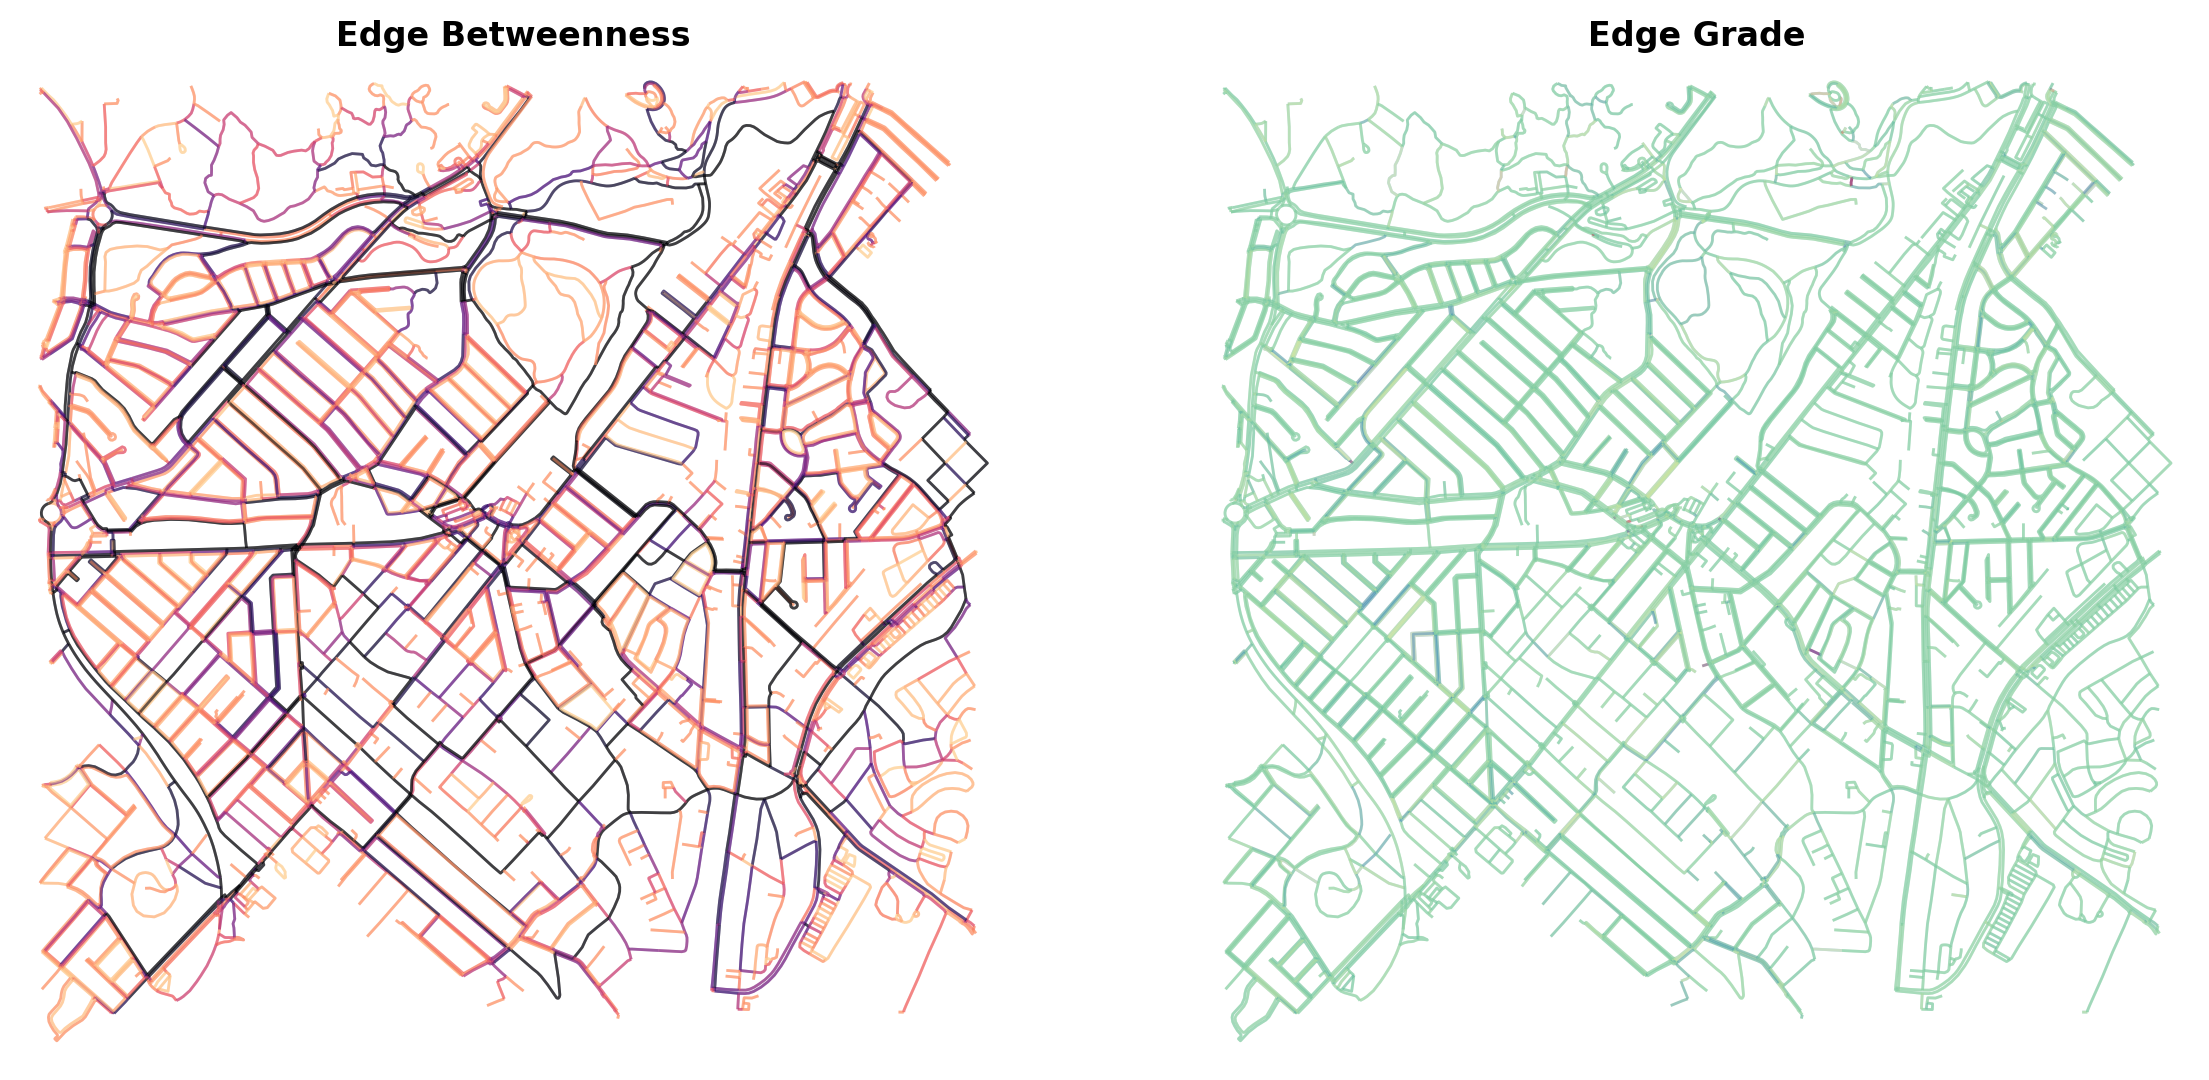

In [33]:
fig, ax = plt.subplots(1,2,figsize=(14,7),dpi=200)

ox.plot_graph(G, node_size=0, bgcolor='white', edge_linewidth=1.0,
              edge_color=ecs1, edge_alpha=0.5, ax=ax[0], show=False, close=False)

ox.plot_graph(G, node_size=0, bgcolor='white', edge_linewidth=1.0,
              edge_color=ecs2, edge_alpha=0.5, ax=ax[1], show=False, close=False)


ax[0].set_title('Edge Betweenness',fontweight='bold')
ax[1].set_title('Edge Grade',fontweight='bold')


plt.show()

_________
### Your turn! (15 minutes)

With a partner: 
1. Find the latitute and longitude of where you're from (could be birthplace, where you call home, where you grew up, etc.)
2. Use `osmnx` to collect the street network within a 2 mile radius of your home coordinates
3. Find a way to quantify the dissimilarities between these two networks
4. Compare these street networks to Erdős-Rényi graphs with the same size/density
__________

In [34]:
pass

## Geopandas

`GeoPandas` is a Python library that extends the functionality of Pandas to support geospatial data. It provides tools for working with vector data, enabling the analysis and visualization of spatial datasets such as points, lines, and polygons. Built on top of Pandas and shapely, and integrating seamlessly with Fiona and pyproj, GeoPandas simplifies handling geospatial data, making it accessible to data scientists and analysts without the need for specialized GIS software.

Geopandas handles spatial data types, known as *Points*, *LineStrings*, and *Polygons* using `shapely` geometries. It enables us to do a range of spatial analyses, such as buffering, intersection, union, spatial joins, and clipping. It supports reading from and writing to common geospatial file formats, such as Shapefiles, GeoJSON, and GeoPackage.


**References**
1. Jordahl, K. (2014). GeoPandas: Python tools for geographic data. https://geopandas.org

- https://geopandas.org/en/stable/docs/user_guide.html

__________


### Shapefiles

GeoPandas is built to work seamlessly with geospatial data in various formats, with Shapefiles being one of the most widely used. Shapefiles are a geospatial vector data format developed by ESRI, widely used for representing geographic features like points, lines, and polygons. Despite their ubiquity, Shapefiles have some limitations that users should understand when working with GeoPandas.

#### Key Components of a Shapefile
A Shapefile is actually a collection of at least three mandatory files:
1. **.shp**: Stores geometry data (e.g., points, line segments, or polygons).
2. **.shx**: Index file for quick access to the geometry data in the `.shp`.
3. **.dbf**: Stores attribute data (e.g., names, IDs, or other metadata) in tabular form.

Optional files include:
- **.prj**: Specifies the projection and coordinate reference system (CRS).
- **.cpg**: Stores character encoding information.
- **.xml**: Metadata about the Shapefile.


**Terrific resource can be found here!**
- https://github.com/mszell/geospatialdatascience/tree/main
- https://pygis.io/docs/a_intro.html

### Other Geospatial File Formats Supported by GeoPandas

GeoPandas supports a variety of more modern and flexible file formats:

#### GeoJSON
- **Description**: A lightweight, JSON-based format for encoding a variety of geographic data structures.
- **Strengths**:
  - Human-readable and easy to parse.
  - Ideal for web applications due to its JSON format.
  - Supports multiple geometry types in a single file.
- **Limitations**:
  - Limited support for very large datasets.
  - Less efficient for heavy computations compared to binary formats.

#### GeoPackage
- **Description**: A modern, SQLite-based container format for vector and raster data.
- **Strengths**:
  - Single-file format, unlike Shapefiles.
  - Supports large datasets and complex attribute data.
  - Handles projections and CRS more robustly.
- **Limitations**:
  - Larger file size compared to some lightweight formats.
  - Newer standard, so not universally supported by older software.

______________


### **GeoPandas I/O Capabilities**
GeoPandas uses Fiona under the hood for geospatial file I/O, enabling support for these formats. Key functions include:
1. **Reading Geospatial Files**:
   ```python
   import geopandas as gpd
   gdf = gpd.read_file("path/to/file.shp")
   
   ```

2. **Writing Geospatial Files**:
   ```python
   gdf.to_file("path/to/output.geojson", driver="GeoJSON")
   
   ```

3. **Handling CRS**:
   GeoPandas automatically reads CRS metadata when present:
   ```python
   gdf.crs  # Access CRS
   gdf = gdf.to_crs("EPSG:4326")  # Reproject to a new CRS
   ```

<!-- 
phil chodrow information measure
use post office datasets -->

In [35]:
import geopandas as gpd

In [36]:
ma = gpd.read_file('data/tl_2020_25_tract')

In [37]:
ma.head()

STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      25      009  265102  25009265102  2651.02  Census Tract 2651.02  G5020   
1      25      009  268200  25009268200     2682     Census Tract 2682  G5020   
2      25      009  268400  25009268400     2684     Census Tract 2684  G5020   
3      25      009  250500  25009250500     2505     Census Tract 2505  G5020   
4      25      027  731300  25027731300     7313     Census Tract 7313  G5020   

  FUNCSTAT     ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S  16318373   134252  +42.7338220  -070.9600766   
1        S  10737361   364499  +42.8117773  -070.9054643   
2        S   3065747  4715475  +42.8054407  -070.8329685   
3        S    300558     3894  +42.7169313  -071.1693673   
4        S    743090     7345  +42.2513743  -071.8152408   

                                            geometry  
0  POLYGON ((-70.99091 42.73399, -70.99089 42.734...  
1  POLYGON ((-70.92052 42.79103, -70.9205 42.7910...  
2  POLYGON ((-70.87547 42.79793, -70.87547 42.797...  
3  POLYGON ((-71.17166 42.72127, -71.1709 42.7208...  
4  POLYGON ((-71.82361 42.24948, -71.8228 42.2499...

What do we notice here?

_______

<Axes: >

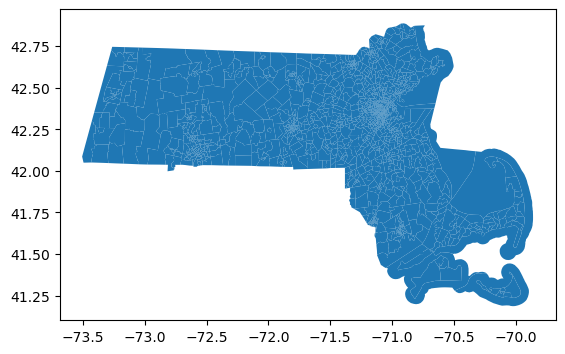

In [38]:
ma.plot()

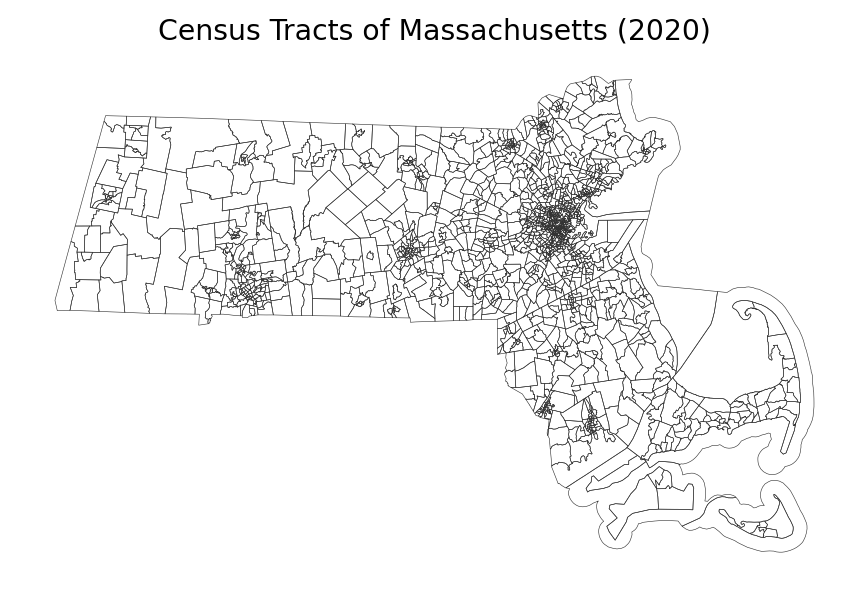

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=170)

ma.plot(fc='none', ec='.2', lw=0.25, ax=ax)
ax.set_title('Census Tracts of Massachusetts (2020)')
ax.set_axis_off()

plt.show()

### Merging shapefiles with data

In [40]:
clim = pd.read_csv('data/ma_clim.csv')
clim.head()

id  life_expectancy  self_reported_physical_health  \
0  34984         0.463466                       0.546088   
1  34985         0.842463                       0.752245   
2  34986         0.886306                       0.987106   
3  34988         0.594612                       0.821014   
4  34993         0.188828                       0.252710   

   self_reported_mental_health  drug_overdose_deaths_per_100_000_people  \
0                     0.629462                                 0.603549   
1                     0.806395                                 0.603549   
2                     0.972870                                 0.603549   
3                     0.903088                                 0.603549   
4                     0.270477                                 0.603549   

   alcohol_abuse  suicide_rates  current_diabetes  current_adult_asthma  \
0       0.373029       0.365998          0.394437              0.486654   
1       0.175318       0.365998          0.636471              0.650460   
2       0.238639       0.365998          0.913464              0.954555   
3       0.487845       0.365998          0.546841              0.871304   
4       0.798826       0.365998          0.125561              0.516453   

     stroke  ...  social_economic  infrastructure  environment  cc_health  \
0  0.275036  ...         0.538874        0.244333     0.797744   0.343846   
1  0.394204  ...         0.603291        0.413532     0.782838   0.327543   
2  0.930724  ...         0.873837        0.541954     0.796813   0.260636   
3  0.584045  ...         0.798237        0.470735     0.697917   0.390933   
4  0.275036  ...         0.316648        0.195124     0.614488   0.305656   

   cc_social_economic  cc_extreme_events  baseline  climate_change  \
0            0.419473           0.912341  0.496797        0.601826   
1            0.404224           0.912341  0.633500        0.583265   
2            0.412724           0.912341  0.858999        0.525501   
3            0.444987           0.976046  0.692181        0.768630   
4            0.315402           0.976169  0.241294        0.659768   

   cvi_overall       geo_id  
0     0.547525  25017311700  
1     0.654402  25017311800  
2     0.830267  25017311900  
3     0.786493  25017312100  
4     0.354167  25017312502  

[5 rows x 233 columns]

In [41]:
clim.columns = list(clim.columns)[:-1]+['GEOID']
clim.head()

id  life_expectancy  self_reported_physical_health  \
0  34984         0.463466                       0.546088   
1  34985         0.842463                       0.752245   
2  34986         0.886306                       0.987106   
3  34988         0.594612                       0.821014   
4  34993         0.188828                       0.252710   

   self_reported_mental_health  drug_overdose_deaths_per_100_000_people  \
0                     0.629462                                 0.603549   
1                     0.806395                                 0.603549   
2                     0.972870                                 0.603549   
3                     0.903088                                 0.603549   
4                     0.270477                                 0.603549   

   alcohol_abuse  suicide_rates  current_diabetes  current_adult_asthma  \
0       0.373029       0.365998          0.394437              0.486654   
1       0.175318       0.365998          0.636471              0.650460   
2       0.238639       0.365998          0.913464              0.954555   
3       0.487845       0.365998          0.546841              0.871304   
4       0.798826       0.365998          0.125561              0.516453   

     stroke  ...  social_economic  infrastructure  environment  cc_health  \
0  0.275036  ...         0.538874        0.244333     0.797744   0.343846   
1  0.394204  ...         0.603291        0.413532     0.782838   0.327543   
2  0.930724  ...         0.873837        0.541954     0.796813   0.260636   
3  0.584045  ...         0.798237        0.470735     0.697917   0.390933   
4  0.275036  ...         0.316648        0.195124     0.614488   0.305656   

   cc_social_economic  cc_extreme_events  baseline  climate_change  \
0            0.419473           0.912341  0.496797        0.601826   
1            0.404224           0.912341  0.633500        0.583265   
2            0.412724           0.912341  0.858999        0.525501   
3            0.444987           0.976046  0.692181        0.768630   
4            0.315402           0.976169  0.241294        0.659768   

   cvi_overall        GEOID  
0     0.547525  25017311700  
1     0.654402  25017311800  
2     0.830267  25017311900  
3     0.786493  25017312100  
4     0.354167  25017312502  

[5 rows x 233 columns]

In [42]:
clim['GEOID'].head()

0    25017311700
1    25017311800
2    25017311900
3    25017312100
4    25017312502
Name: GEOID, dtype: int64

In [43]:
clim['GEOID'] = clim['GEOID'].astype(str)
ma['GEOID'] = ma['GEOID'].astype(str)

In [44]:
list(clim.columns)[-10:]

['social_economic',
 'infrastructure',
 'environment',
 'cc_health',
 'cc_social_economic',
 'cc_extreme_events',
 'baseline',
 'climate_change',
 'cvi_overall',
 'GEOID']

In [45]:
data_col = 'cvi_overall'

ma_new = ma.merge(clim[['GEOID',data_col]], how='left', on='GEOID')
ma_new.head()

STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      25      009  265102  25009265102  2651.02  Census Tract 2651.02  G5020   
1      25      009  268200  25009268200     2682     Census Tract 2682  G5020   
2      25      009  268400  25009268400     2684     Census Tract 2684  G5020   
3      25      009  250500  25009250500     2505     Census Tract 2505  G5020   
4      25      027  731300  25027731300     7313     Census Tract 7313  G5020   

  FUNCSTAT     ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S  16318373   134252  +42.7338220  -070.9600766   
1        S  10737361   364499  +42.8117773  -070.9054643   
2        S   3065747  4715475  +42.8054407  -070.8329685   
3        S    300558     3894  +42.7169313  -071.1693673   
4        S    743090     7345  +42.2513743  -071.8152408   

                                            geometry  cvi_overall  
0  POLYGON ((-70.99091 42.73399, -70.99089 42.734...     0.259322  
1  POLYGON ((-70.92052 42.79103, -70.9205 42.7910...     0.513305  
2  POLYGON ((-70.87547 42.79793, -70.87547 42.797...     0.238324  
3  POLYGON ((-71.17166 42.72127, -71.1709 42.7208...     0.798346  
4  POLYGON ((-71.82361 42.24948, -71.8228 42.2499...     0.530552

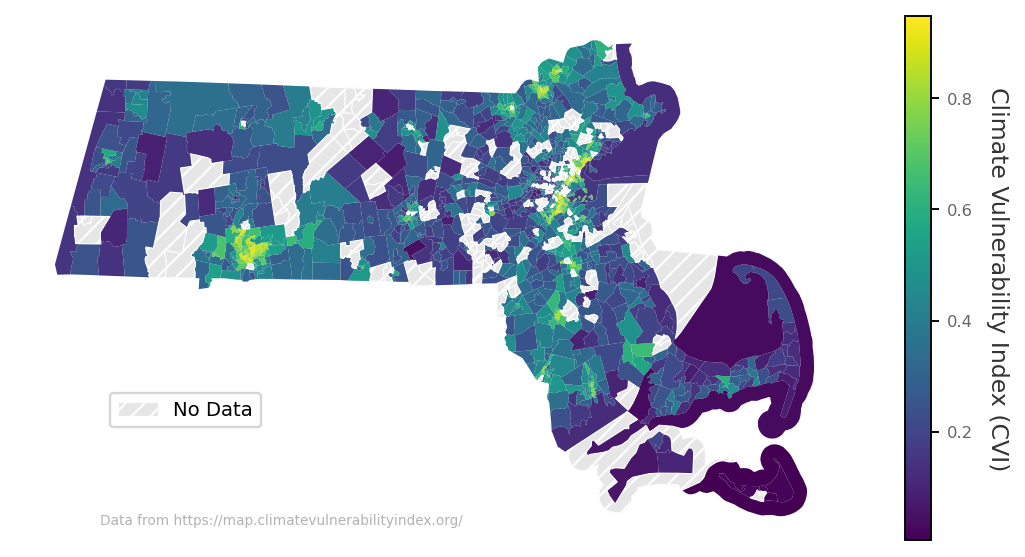

In [46]:
from matplotlib.patches import Patch
from matplotlib import colormaps
import matplotlib.cm as cm

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=170)

cmap = colormaps['viridis']
norm = plt.Normalize(vmin=ma_new[data_col].min(), vmax=ma_new[data_col].max())

# Plot the data with the colormap for non-missing values
ma_new[ma_new[data_col].notna()].plot(column=data_col, cmap=cmap, ax=ax)

# Add the missing data with a checkered (hatched) pattern
ma_new[ma_new[data_col].isna()].plot(ax=ax, color='.9', edgecolor='.99', lw=0.5, hatch='///')

# Create a custom legend
ax.legend(handles=[Patch(facecolor='.9', edgecolor='.99', hatch='///',
                         lw=0.5, label='No Data')],
          loc=2, bbox_to_anchor=[0.1,0.3], fontsize='small')

# Add a colorbar with a label
sm = cm.ScalarMappable(cmap=cmap, norm=norm)  # ScalarMappable for the colorbar
sm._A = []  # Dummy array for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')  # Add colorbar to the plot
cbar.set_label('Climate Vulnerability Index (CVI)', rotation=270, labelpad=15, color='.2')
cbar.ax.tick_params(labelsize='x-small', labelcolor='.4')

ax.text(0.1, 0.025, 'Data from https://map.climatevulnerabilityindex.org/', color='.7', fontsize='xx-small',
        ha='left', va='bottom', transform=ax.transAxes)
ax.set_axis_off()


plt.show()

### Tons more great resources here:
https://github.com/mszell/geospatialdatascience/tree/main

![](images/szell_geospatial.png)

### Spatial Joins in `Geopandas`

Spatial joins are a powerful GIS operation that combines attributes from two datasets based on their spatial relationships. Unlike traditional tabular joins, which rely on matching keys, spatial joins depend on how geometries interact, such as whether one geometry contains another or overlaps with it. For example, you can use spatial joins to determine which census tract a point (like a school or store) falls into or to aggregate data by spatial boundaries. See terrific tutorial about spatial joins here: https://pygis.io/docs/e_spatial_joins.html! Drawing a bunch from it's great materials below.

We'll practice by performing spatial joins to associate point data with Massachusetts (MA) census tracts. We'll generate random points within the bounding box of the MA shapefile and join these points to their corresponding census tracts.

Exercise: We're going to randomly generate points data throughout the bounding box of MA, and spatial join these points to census tracts.

In [47]:
minx, miny, maxx, maxy = ma.total_bounds
print(f"Bounding box: ({minx}, {miny}, {maxx}, {maxy})")

n_points = 10000

# Generate random latitudes and longitudes within the bounding box
random_lons = np.random.uniform(minx, maxx, n_points)
random_lats = np.random.uniform(miny, maxy, n_points)

random_points = pd.DataFrame({'lat':random_lats,'lon':random_lons})

Bounding box: (-73.50820999999999, 41.187053, -69.85886099999999, 42.886778)


In [48]:
random_points.head()

lat        lon
0  41.348976 -72.716133
1  42.653198 -70.076800
2  42.702141 -71.039571
3  42.487032 -71.647537
4  42.075592 -70.850412

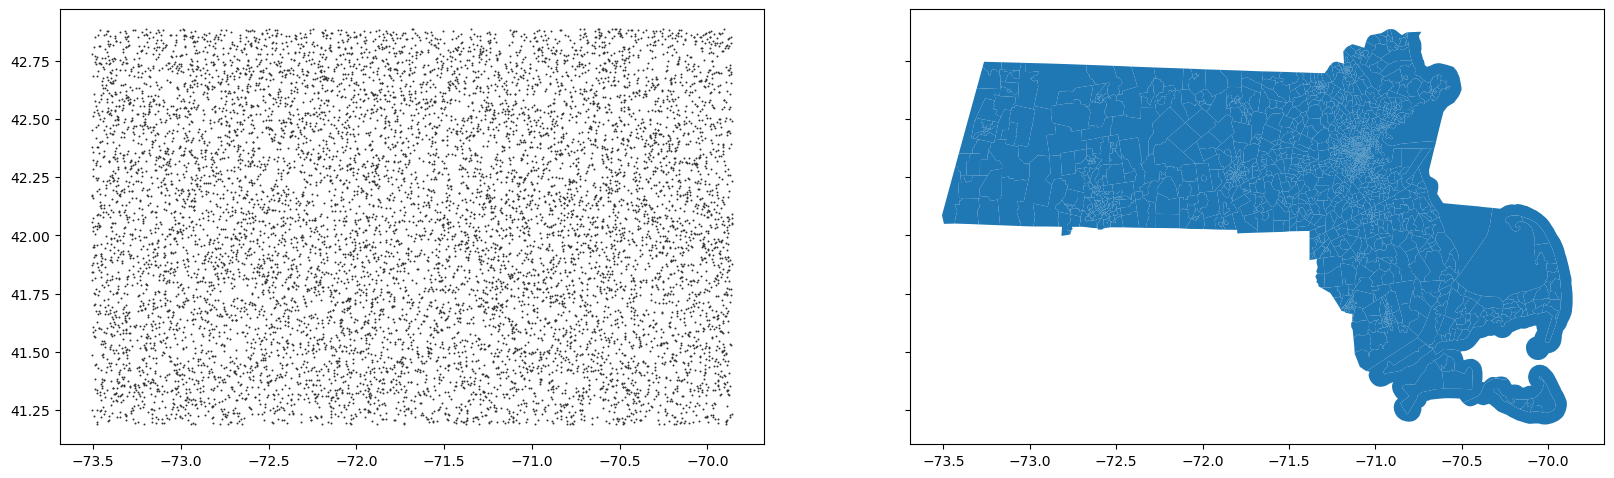

In [49]:
fig, ax = plt.subplots(1,2,figsize=(20,5.65),dpi=100,
                       gridspec_kw={'width_ratios':[1,1]},sharex=True,sharey=True)

ax[0].scatter(random_points['lon'].values,random_points['lat'].values,color='.2', s=2, lw=0)

ma.plot(ax=ax[1])

plt.show()

**We'll need a GeoDataFrame in order to do the spatial join!**

In [50]:
from shapely.geometry import Point
# Create a GeoDataFrame for these points
random_points = gpd.GeoDataFrame({
    'id': range(n_points),  # Assign unique IDs
    'latitude': random_lats,
    'longitude': random_lons
}, geometry=[Point(xy) for xy in zip(random_lons, random_lats)], crs="EPSG:4326")


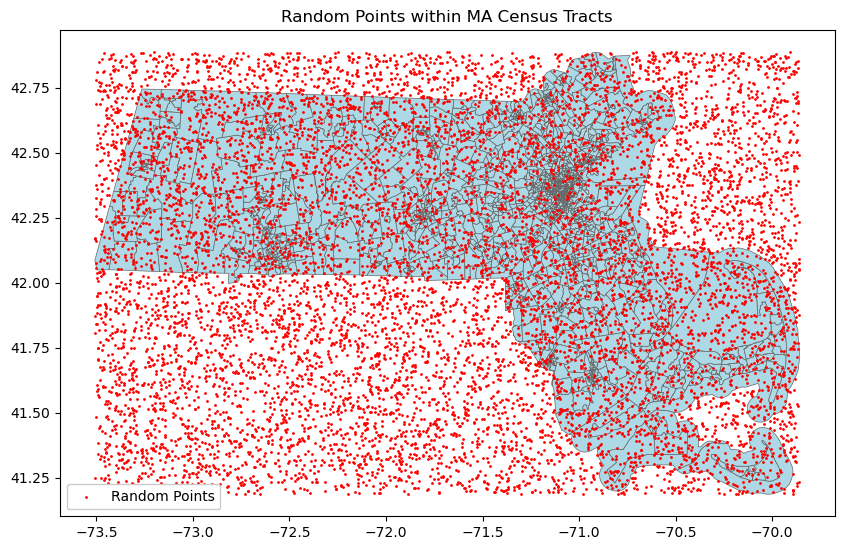

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot census tracts
ma.plot(ax=ax, fc='lightblue',ec='.4', linewidth=0.5)
# ma.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot random points
random_points.plot(ax=ax, color='red', markersize=1, label='Random Points')

# Add legend and title
plt.legend(framealpha=1, loc=3)
plt.title('Random Points within MA Census Tracts')
plt.show()

In [52]:
points_with_tracts = gpd.sjoin(random_points, ma, how='left', predicate='within')

/tmp/ipykernel_4309/2835737534.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  points_with_tracts = gpd.sjoin(random_points, ma, how='left', predicate='within')


**Oh no! CRS :(**

In [53]:
print(random_points.crs)  # Should be EPSG:4326
print(ma.crs)  # Should be EPSG:4269

EPSG:4326
EPSG:4269


In [54]:
random_points = random_points.to_crs(ma.crs)

In [55]:
points_with_tracts = gpd.sjoin(random_points, ma, how='left', predicate='within')

In [56]:
# Count points in each census tract
points_per_tract = points_with_tracts.groupby('GEOID').size().reset_index(name='point_count')

# Merge counts back to census tracts
ma_tracts_with_counts = ma.merge(points_per_tract, on='GEOID', how='left')
ma_tracts_with_counts['point_count'] = ma_tracts_with_counts['point_count'].fillna(0)

In [57]:
ma_tracts_with_counts

STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
0         25      009  265102  25009265102  2651.02  Census Tract 2651.02   
1         25      009  268200  25009268200     2682     Census Tract 2682   
2         25      009  268400  25009268400     2684     Census Tract 2684   
3         25      009  250500  25009250500     2505     Census Tract 2505   
4         25      027  731300  25027731300     7313     Census Tract 7313   
...      ...      ...     ...          ...      ...                   ...   
1615      25      025  070802  25025070802   708.02   Census Tract 708.02   
1616      25      025  061202  25025061202   612.02   Census Tract 612.02   
1617      25      025  070801  25025070801   708.01   Census Tract 708.01   
1618      25      025  060601  25025060601   606.01   Census Tract 606.01   
1619      25      025  070901  25025070901   709.01   Census Tract 709.01   

      MTFCC FUNCSTAT     ALAND   AWATER     INTPTLAT      INTPTLON  \
0     G5020        S  16318373   134252  +42.7338220  -070.9600766   
1     G5020        S  10737361   364499  +42.8117773  -070.9054643   
2     G5020        S   3065747  4715475  +42.8054407  -070.8329685   
3     G5020        S    300558     3894  +42.7169313  -071.1693673   
4     G5020        S    743090     7345  +42.2513743  -071.8152408   
...     ...      ...       ...      ...          ...           ...   
1615  G5020        S    129953        0  +42.3417055  -071.0802334   
1616  G5020        S    380810     4897  +42.3387527  -071.0625085   
1617  G5020        S     61235        0  +42.3399771  -071.0825322   
1618  G5020        S    140332        0  +42.3392514  -071.0489604   
1619  G5020        S     57691        0  +42.3377169  -071.0795662   

                                               geometry  point_count  
0     POLYGON ((-70.99091 42.73399, -70.99089 42.734...          1.0  
1     POLYGON ((-70.92052 42.79103, -70.9205 42.7910...          3.0  
2     POLYGON ((-70.87547 42.79793, -70.87547 42.797...          0.0  
3     POLYGON ((-71.17166 42.72127, -71.1709 42.7208...          0.0  
4     POLYGON ((-71.82361 42.24948, -71.8228 42.2499...          0.0  
...                                                 ...          ...  
1615  POLYGON ((-71.08315 42.34162, -71.08303 42.341...          0.0  
1616  POLYGON ((-71.06553 42.33603, -71.06551 42.336...          1.0  
1617  POLYGON ((-71.08468 42.34029, -71.08431 42.340...          0.0  
1618  POLYGON ((-71.05238 42.3398, -71.0519 42.34019...          0.0  
1619  POLYGON ((-71.08181 42.33856, -71.08116 42.338...          0.0  

[1620 rows x 14 columns]

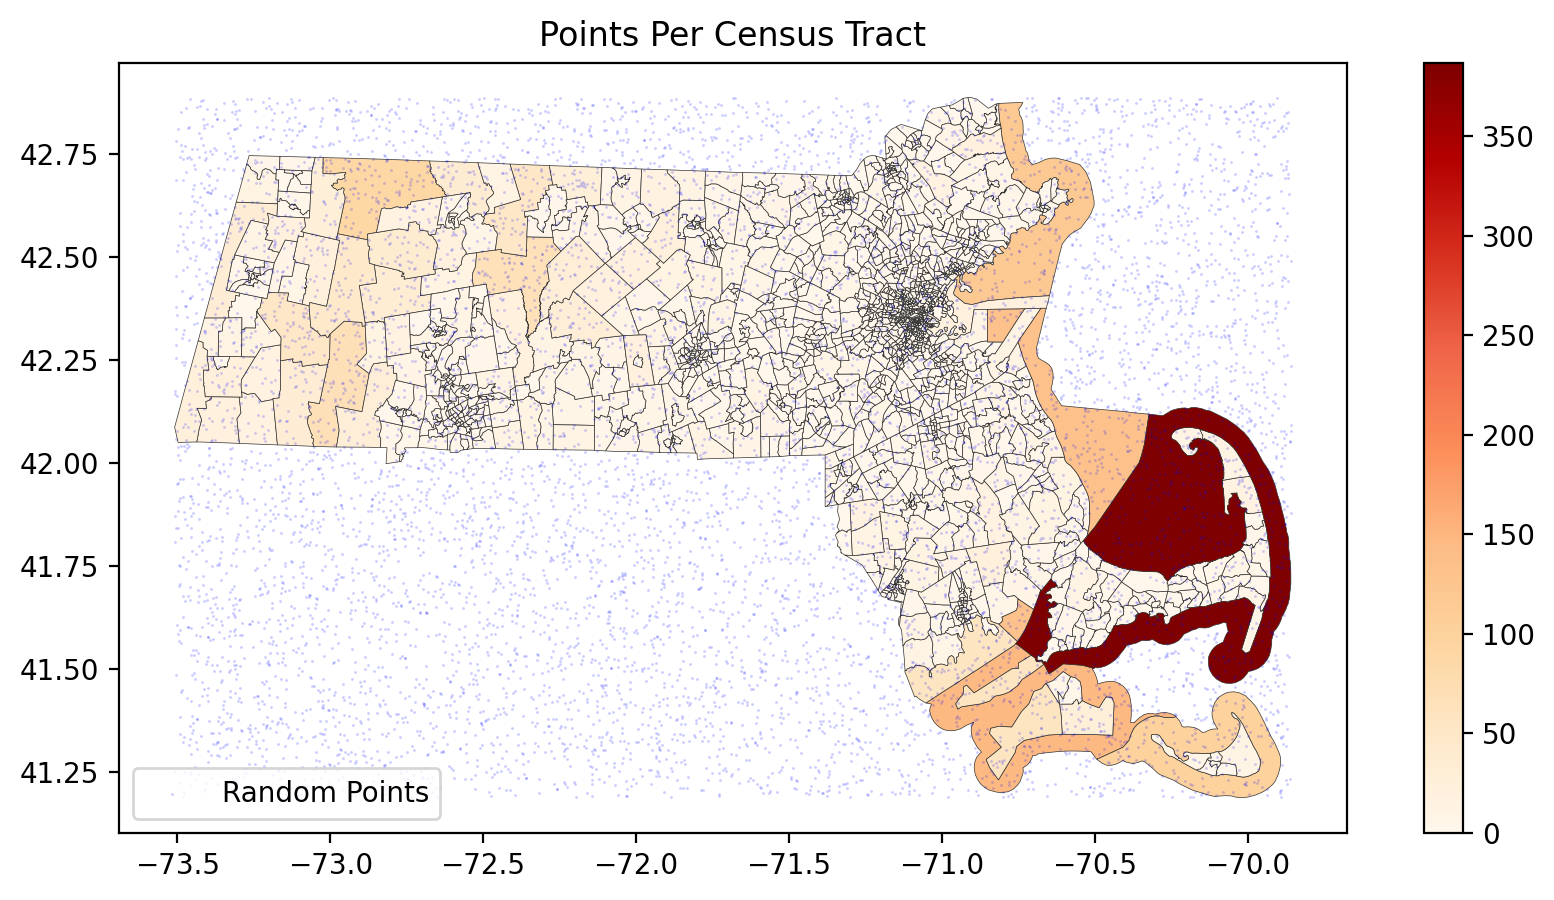

In [58]:
fig, ax = plt.subplots(1,1,figsize=(10, 5), dpi=200)

# Plot census tracts colored by the number of points
ma_tracts_with_counts.plot(column='point_count', lw=0.25, 
                           ec='.2', cmap='OrRd', legend=True, ax=ax)

# Plot random points
random_points.plot(ax=ax, color='blue', markersize=1, lw=0, label='Random Points', alpha=0.2)

# Add legend and title
ax.legend(loc=3)
ax.set_title('Points Per Census Tract')

plt.show()

### If there's time...
Try to find point data that you can spatially join with shapefile data. What challenges might you foresee?

In [59]:
pass

__________
## Next time...
There is no next time!!
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://asmithh.github.io/network-science-data-book/intro.html
    - Github: https://github.com/asmithh/network-science-data-book
    - Syllabus and course details: https://brennanklein.com/phys7332-fall24
2. Penrose, M. D. (2003). *Random Geometric Graphs.* Oxford University Press. https://doi.org/10.1093/acprof:oso/9780198506263.001.0001
3. Gilbert, E. N. (1961). Random plane networks. *Journal of the Society for Industrial and Applied Mathematics*, 9(4), 533–543. https://doi.org/10.1137/0109045
4. Dall, J., & Christensen, M. (2002). Random geometric graphs. *Physical Review E*, 66(1), 016121. https://doi.org/10.1103/PhysRevE.66.016121
5. Penrose, M. D. (1999). On $k$-connectivity for a geometric random graph. *Random Structures & Algorithms*, 15(2), 145–164. https://doi.org/10.1002/(SICI)1098-2418(199909)15:2%3C145::AID-RSA2%3E3.0.CO;2-G
6. Barthelemy, M. (2011). Spatial networks. *Physics Reports*, 499(1–3), 1–101. https://doi.org/10.1016/j.physrep.2010.11.002
7. Haenggi, M. (2009). *Stochastic Geometry for Wireless Networks.* Cambridge University Press. https://doi.org/10.1017/CBO9781139043816
8. Eppstein, D., Goodrich, M. T., & Trott, L. (2009, November). Going off-road: transversal complexity in road networks. In Proceedings of the 17th *ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems* (pp. 23-32). https://doi.org/10.1145/1653771.1653778
9. Boeing, G. (2024). Modeling and Analyzing Urban Networks and Amenities with OSMnx. Working paper. https://geoffboeing.com/publications/osmnx-paper/.
10. Boeing, G. (2017). OSMnx: New methods for acquiring, constructing, analyzing, and visualizing complex street networks. *Computers, Environment and Urban Systems*, 65, 126–139. https://doi.org/10.1016/j.compenvurbsys.2017.05.004.
11. Boeing, G. (2022). Street network models and indicators for every urban area in the world. *Geographical Analysis*, 54(3), 519-535. https://doi.org/10.1111/gean.12281.